In [1]:
import numpy as np
import torch, os
import torch.nn as nn
from model_cond_flow import get_model, Architecture
from data import get_data
import tqdm
from partition import *
import config as c
#import seaborn as sns
#from iResNet_cond import *
import matplotlib.pyplot as plt
from tower import TowerRepresentation
cuda = torch.cuda.is_available()
device = 'cpu'#torch.device("cuda" if cuda else "cpu")
model_folder_path = './models'
c.batch_size = 1
np.sort(os.listdir(model_folder_path))
import math
 
def euler_from_quaternion(x, y, z, w):
        """
        Convert a quaternion into euler angles (roll, pitch, yaw)
        roll is rotation around x in radians (counterclockwise)
        pitch is rotation around y in radians (counterclockwise)
        yaw is rotation around z in radians (counterclockwise)
        """
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        roll_x = math.atan2(t0, t1)
     
        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        pitch_y = math.asin(t2)
     
        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        yaw_z = math.atan2(t3, t4)
     
        return roll_x, pitch_y, yaw_z # in radians

In [2]:
model_folder_path = './models'
checkpoint_name = np.sort(os.listdir(model_folder_path))[-1]
print(checkpoint_name)
trained_model_path = model_folder_path + '/{}'.format(checkpoint_name)

checkpoint_checkpoint_847146.pt


In [3]:
model_dict = torch.load(trained_model_path, map_location = 'cpu')['model']
model = Architecture(device)
model.load_state_dict(model_dict, strict=False)
#model = DataParallel(model)

<All keys matched successfully>

In [4]:
train_dataset, valid_dataset, train_loader, valid_loader = get_data()
load = iter(train_loader)

In [5]:
batch            = next(load)
x, v, d             = batch
x, v, d             = x, v, d#x.to(device), v.to(device)


In [6]:
x_c, v_c, x_q, v_q, d_c, d_q = partition(x, v, d)
print('x_c:', x_c.shape)
print('v_c:', v_c.shape)
print('x_q:', x_q.shape)
print('v_q:', v_q.shape)
print('d_c:', d_c.shape)
print('d_q:', d_q.shape)

x_c: torch.Size([1, 29, 3, 64, 64])
v_c: torch.Size([1, 29, 7])
x_q: torch.Size([1, 3, 64, 64])
v_q: torch.Size([1, 7])
d_c: torch.Size([1, 29, 7, 64, 64])
d_q: torch.Size([1, 7, 64, 64])


In [7]:
v_re, _ = model.test(x_c, v_c, x_q, v_q, d_c, d_q)

0 0


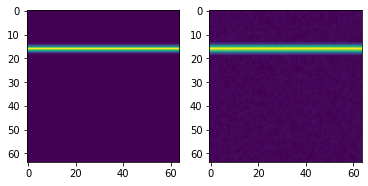

0 1


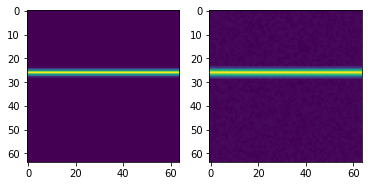

0 2


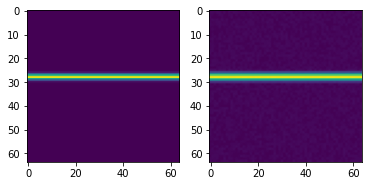

0 3


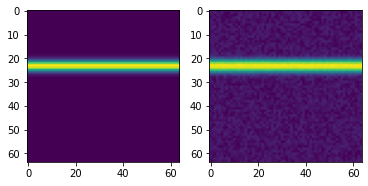

0 4


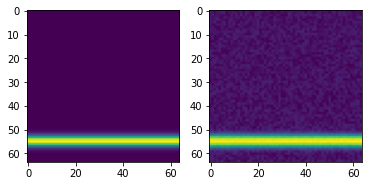

0 5


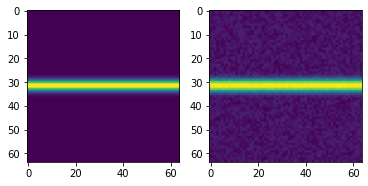

0 6


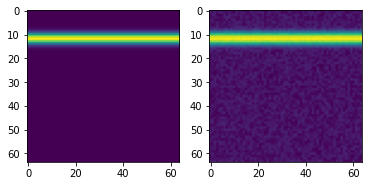

In [8]:
for i in range(d.shape[0]):
    for idx in range(7):
        print(i, idx)
        out_idx = v_re[i,idx]#.permute(1, 2, 0)#.detach().numpy()
        #print(out_idx.max(), out_idx.min())
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(d_q[i,idx].numpy())
        plt.subplot(1,2,2)
        #print(out_idx.detach().cpu().numpy().shape)
        plt.imshow(out_idx.detach().cpu().numpy())
        plt.show()

In [9]:
v_sa = model.sample(x_c, v_c, x_q, d_c)

<ipython-input-10-a294c43b7e4d>:24: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(True)


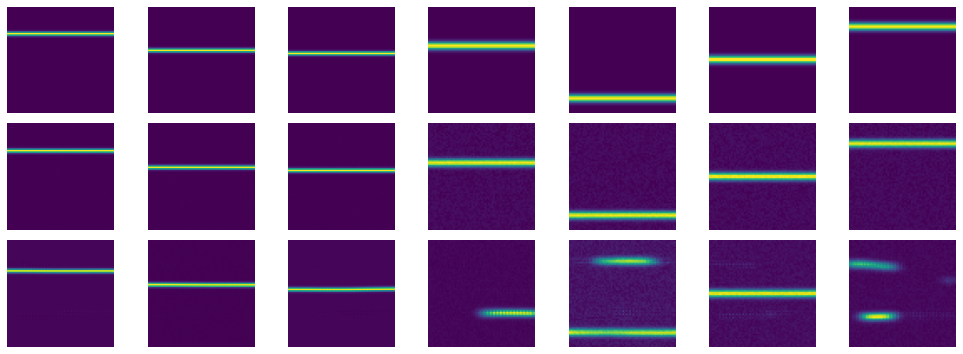

In [10]:
bs = 0

nrows, ncols = 3, 7
figsize = [14, 5]

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
for j in range(nrows):
    for i in range(ncols):
        axi = ax[j][i]
        idx = i
        #axi.imshow(d[bs,idx].numpy())
        if j == 0:
            axi.imshow(d_q[bs,idx].numpy())
        elif j == 1:
            axi.imshow(torch.sigmoid(v_re[bs,idx]).detach().numpy())
        else:
            axi.imshow(torch.sigmoid(v_sa[bs,idx]).detach().numpy())
        #plt.subplot(7, d.shape[0], idx+1)
        #print(out_idx.detach().cpu().numpy().shape)
        #plt.imshow(out_idx.detach().cpu().numpy())
        
        axi.axis('off')

plt.tight_layout(True)
plt.show()

In [11]:
for i in range(ncols):
    idx = i

    a = torch.sigmoid(v_re[bs, idx]).detach()
    a_pix = np.unravel_index(a.argmax(), a.shape)[0]
    if idx < 3:
        print( 'x est: ', (40*(a_pix/64.)-20) + 20./64.)
        print( 'x tru: ', v_q[bs, idx].item())
        print('------------------')
    else:
        print( 'q est: ', (2*(a_pix/64.)-1) + 1./64.)
        print( 'q tru: ', v_q[bs, idx].item())
        print('------------------')

20/64, 1/64

x est:  -9.6875
x tru:  -9.758835792541504
------------------
x est:  -3.4375
x tru:  -3.447014808654785
------------------
x est:  -2.1875
x tru:  -2.325040817260742
------------------
q est:  -0.265625
q tru:  -0.260036438703537
------------------
q est:  0.734375
q tru:  0.736188530921936
------------------
q est:  -0.015625
q tru:  0.0
------------------
q est:  -0.609375
q tru:  -0.6248260140419006
------------------


(0.3125, 0.015625)

import os, tensorflow as tf

losses = []
for path in os.listdir('./log'):
    for e in tf.compat.v1.train.summary_iterator(os.path.join('./log',path)):
        for v in e.summary.value:
            if v.tag == 'training/loss':
                loss = v.simple_value
                losses.append(loss)
plt.plot(losses, color='k')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')

<ipython-input-12-6ed92183dc69>:48: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(True)


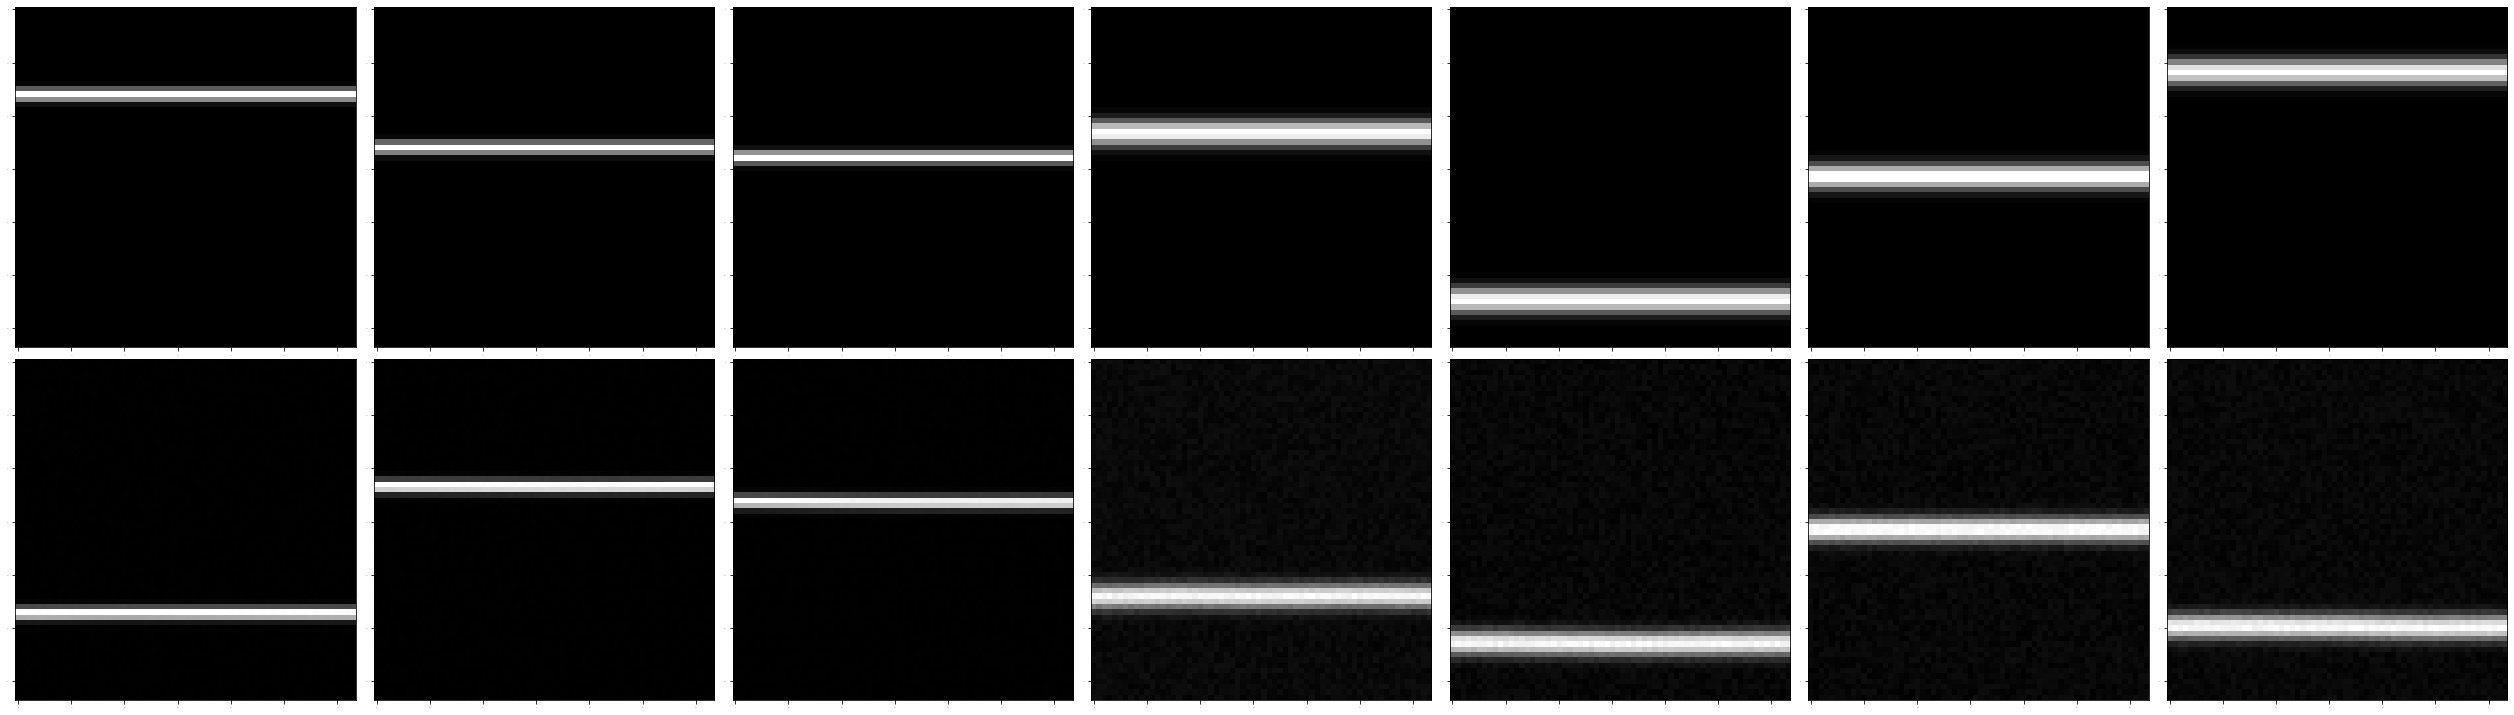

In [12]:
v_sa = model.sample(x_c, v_c, x_q, d_c)
bs = 0
n_labels = 4

nrows, ncols = 2, 7
figsize = [35, 10]

fig = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
for j in range(nrows):
    for i in range(ncols):
        
        plt.subplot(nrows, ncols, j * ncols + i + 1)
        
        #axi = ax[j][i]
        idx = i
        #axi.imshow(d[bs,idx].numpy())
        if j == 0:
            plt.imshow(d_q[bs,idx].numpy(), cmap='gray')
        elif j == 1:
            #axi.imshow(torch.sigmoid(v_re[bs,idx]).detach().numpy())
        #else:
            plt.imshow(torch.sigmoid(v_sa[bs,idx]).detach().numpy(), cmap='gray')
        #plt.xlabel(['x (km)','y (km)','z (km)', '$q_1$', '$q_2$', '$q_3$', '$q_4$'][i], fontsize=32)
        #plt.ylabel(['x (km)','y (km)','z (km)', '$q_1$', '$q_2$', '$q_3$', '$q_4$'][i], fontsize=32)
            
        #if i < 3:
        #    plt.xticks(np.arange(0,64+1, step = 64 // n_labels), np.arange(-20,20+1, step=40 // n_labels), fontsize=24)
        #    plt.yticks(np.arange(0,64+1, step = 64 // n_labels), np.arange(-20,20+1, step=40 // n_labels), fontsize=24)
            
        #else:
        #    plt.xticks(np.arange(0,64+1, step = 64 // n_labels), np.arange(-1,1+0.1, step=2 / n_labels), fontsize=24)
        #    plt.yticks(np.arange(0,64+1, step = 64 // n_labels), np.arange(-1,1+0.1, step=2 / n_labels), fontsize=24)
            
        plt.xticks(fontsize=0)
        plt.yticks(fontsize=0)
            
        #plt.subplot(7, d.shape[0], idx+1)
        #print(out_idx.detach().cpu().numpy().shape)
        #plt.imshow(out_idx.detach().cpu().numpy())
        #labels = [item.get_text() for item in axi.get_xticklabels()]
        #labels = np.arange(-20, 20, step=4)
        #axi.set_xticklabels(labels, minor=False)
        #print(labels)
        #axi.set_xticks(np.arange(0,64, step=64), np.arange(-20,20,step=64))
        
        #axi.axis('off')

plt.tight_layout(True)
plt.show()

<ipython-input-13-462c0c9a941e>:47: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(True)


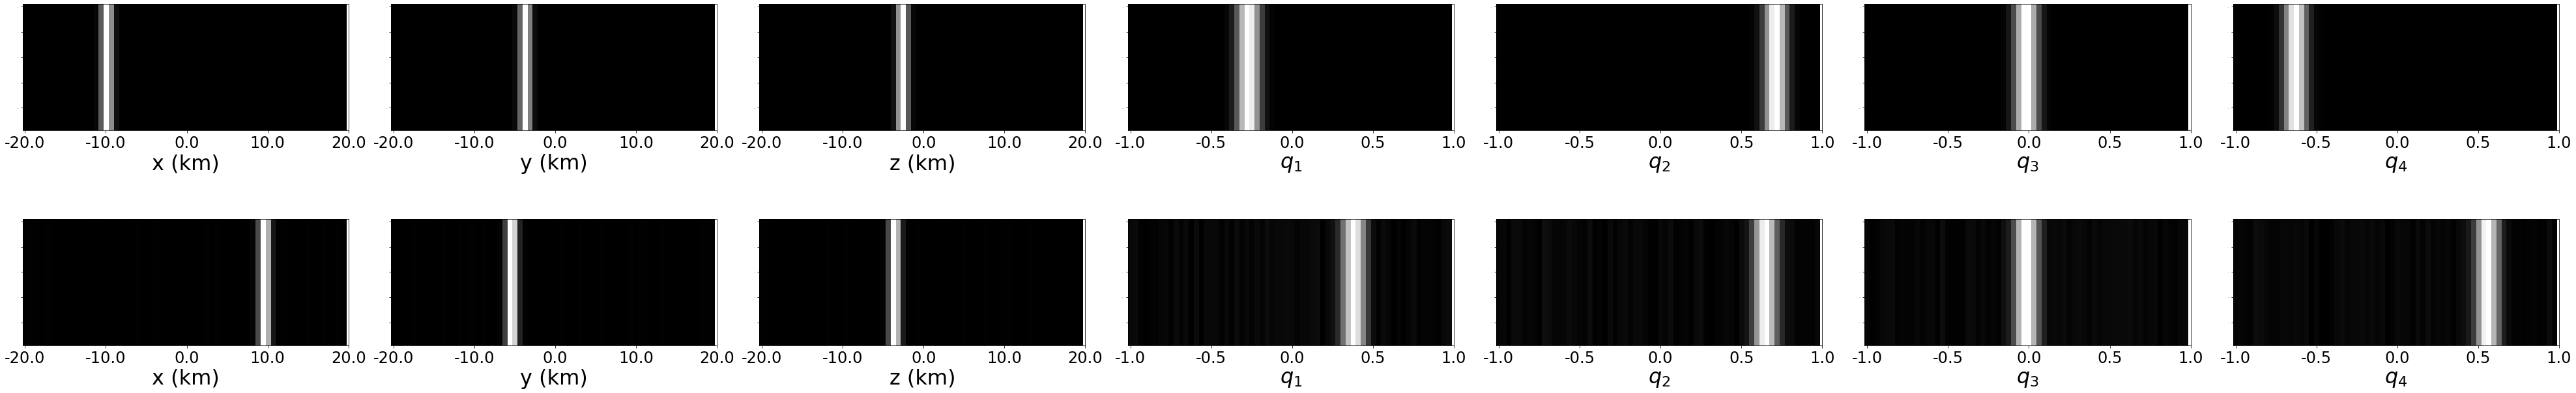

In [13]:

bs = 0
n_labels = 4

nrows, ncols = 2, 7
figsize = [55, 10]

fig = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
for j in range(nrows):
    for i in range(ncols):
        
        plt.subplot(nrows, ncols, j * ncols + i + 1)
        
        #axi = ax[j][i]
        idx = i
        #axi.imshow(d[bs,idx].numpy())
        if j == 0:
           out = plt.imshow(d_q[bs,idx][:,0].repeat(25,1).numpy(), cmap='gray')
        elif j == 1:
            #axi.imshow(torch.sigmoid(v_re[bs,idx]).detach().numpy())
        #else:
            out = plt.imshow(torch.sigmoid(v_sa[bs,idx])[:,0].repeat(25,1).detach().numpy(), cmap='gray')
        plt.xlabel(['x (km)','y (km)','z (km)', '$q_1$', '$q_2$', '$q_3$', '$q_4$'][i], fontsize=32)
        #plt.ylabel(['x (km)','y (km)','z (km)', '$q_1$', '$q_2$', '$q_3$', '$q_4$'][i], fontsize=32)
            
        f = c.img_width
        if i < 3:
            plt.xticks(np.arange(0,f+1, step = f / n_labels), np.arange(-20,20+1, step= 40 / n_labels), fontsize=24)
            #plt.yticks(np.arange(0,64+1, step = 64 // n_labels), np.arange(-20,20+1, step=40 // n_labels), fontsize=24)
            
        else:
            plt.xticks(np.arange(0,f+1, step = f / n_labels), np.arange(-1,1+0.1, step=2 / n_labels), fontsize=24)
            #plt.yticks(np.arange(0,64+1, step = 64 // n_labels), np.arange(-1,1+0.1, step=2 / n_labels), fontsize=24)
            
        plt.yticks(fontsize=0)
            
        #plt.subplot(7, d.shape[0], idx+1)
        #print(out_idx.detach().cpu().numpy().shape)
        #plt.imshow(out_idx.detach().cpu().numpy())
        #labels = [item.get_text() for item in axi.get_xticklabels()]
        #labels = np.arange(-20, 20, step=4)
        #axi.set_xticklabels(labels, minor=False)
        #print(labels)
        #axi.set_xticks(np.arange(0,64, step=64), np.arange(-20,20,step=64))
        
        #axi.axis('off')

plt.tight_layout(True)
plt.show()



In [14]:
np.unravel_index(a.argmax(), a.shape)[0]

12

In [15]:
p = []
pt = []
a1 = []
at = []

MSE_p = 0
MSE_a = 0

e_state = []
t_state = []

for i in range(ncols):
    idx = i

    a = torch.sigmoid(v_sa[bs, idx]).detach().reshape(1,-1)[0]
    a_pix = np.unravel_index(a.argmax(), a.shape)[0]
    
    if idx < 3:
        e = (40*(a_pix/(c.img_width**2))-20) + 20./(c.img_width*2)
        t = v_q[bs, idx].item()
        
    else:
        e = (2*(a_pix/(c.img_width**2))-1) + 1./(c.img_width*2)
        t = v_q[bs, idx].item()
        
        
    print( 'x est: ', e)
    print( 'x tru: ', t)
    
    e_state.append(e)
    t_state.append(t)
    
    
    MSE = np.sqrt((t - e)**2)
    print('RMSE values: ', np.linalg.norm(MSE))
    print('------------------')
    
    if idx < 3:
        MSE_p += MSE
    else:
        MSE_a += MSE
    
20/64, 1/64

x est:  9.775390625
x tru:  -9.758835792541504
RMSE values:  19.534226417541504
------------------
x est:  -5.361328125
x tru:  -3.447014808654785
RMSE values:  1.9143133163452148
------------------
x est:  -3.544921875
x tru:  -2.325040817260742
RMSE values:  1.2198810577392578
------------------
x est:  0.40673828125
x tru:  -0.260036438703537
RMSE values:  0.666774719953537
------------------
x est:  0.67822265625
x tru:  0.736188530921936
RMSE values:  0.057965874671936035
------------------
x est:  0.01611328125
x tru:  0.0
RMSE values:  0.01611328125
------------------
x est:  0.5947265625
x tru:  -0.6248260140419006
RMSE values:  1.2195525765419006
------------------


(0.3125, 0.015625)

In [16]:
e_euler = euler_from_quaternion(e_state[3], e_state[4], e_state[5], e_state[6])
t_euler = euler_from_quaternion(t_state[3], t_state[4], t_state[5], t_state[6])

In [17]:
print(e_euler)
print(t_euler)

(2.0313025591585205, 0.9167134708761915, 1.4324134426325792)
(2.164208372819607, -1.168028157933901, -1.7866373452207254)


In [18]:
RMSE = np.sqrt((np.array(e_euler) - np.array(t_euler)).mean()**2)

print('Euler Attitude -- RMSE values: ', RMSE, 'radians', np.rad2deg(RMSE), 'degrees')

Euler Attitude -- RMSE values:  1.723628867667437 radians 98.75665956425722 degrees


In [19]:
RMSE = np.sqrt((np.array(t_state[:3]) - np.array(e_state[:3])).mean()**2)
print('Position -- RMSE values: ', RMSE, 'km')

Position -- RMSE values:  5.466677347819011 km


In [20]:
est = []
true = v_q[bs].numpy()
N = 5

for _ in tqdm.tqdm(range(N)):
    v_sa_ = model.sample(x_c, v_c, x_q, d_c)
    #v_sa, _ = model.test(x_c, v_c, x_q, v_q, d_c, d_q)
    v_sa_ = torch.sigmoid(v_sa_)
    es = []
    for i in range(ncols):
        idx = i

        a = torch.sigmoid(v_sa[bs, idx]).detach().reshape(1,-1)[0]
        a_pix = np.unravel_index(a.argmax(), a.shape)[0]

        if idx < 3:
            e = (40*(a_pix/(c.img_width**2))-20) + 20./(c.img_width*2)

        else:
            e = (2*(a_pix/(c.img_width**2))-1) + 1./(c.img_width*2)

        es.append(e)
    est.append(es)

est = np.array(est)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.36s/it]


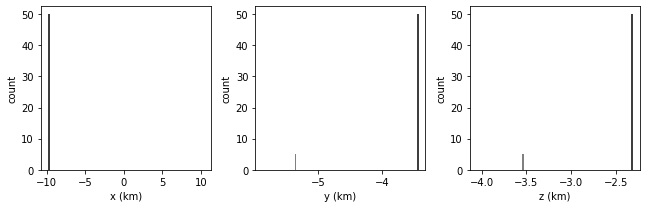

In [21]:
plt.figure(figsize=(7*3,3))
for j in range(3):
    x = est[:,j]
    plt.subplot(1,7,j+1)
    plt.hist(x, bins=80, color='grey')
    plt.ylabel('count')
    plt.xlabel(['x (km)','y (km)','z (km)','q1','q2','q3','q4'][j])
    plt.vlines(true[j], 0, 50, color='k')
plt.tight_layout()
plt.show()

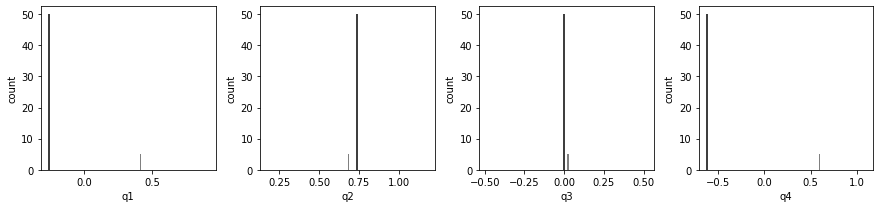

In [22]:
plt.figure(figsize=(7*3,3))
for j in range(3,7):
    x = est[:,j]
    plt.subplot(1,7,j+1)
    plt.hist(x, bins=80, color='grey')
    plt.ylabel('count')
    plt.xlabel(['x (km)','y (km)','z (km)','q1','q2','q3','q4'][j])
    plt.vlines(true[j], 0, 50, color='k')
plt.tight_layout()
plt.show()

In [23]:
true

array([-9.758836  , -3.4470148 , -2.3250408 , -0.26003644,  0.73618853,
        0.        , -0.624826  ], dtype=float32)

In [24]:
est.shape

(5, 7)

In [25]:
est_euler = np.zeros((est.shape[0], 6))
true_euler = np.zeros((6))
for idx in range(est.shape[0]):
    est_euler[idx,:3] = est[idx,:3]
    est_euler[idx,3:] = euler_from_quaternion(est[idx,3], est[idx,4], est[idx,5], est[idx,6])
true_euler[:3] = true[:3]
true_euler[3:] = euler_from_quaternion(true[3], true[4], true[5], true[6])

In [26]:
est_euler.mean(axis=0)

array([ 9.77539062, -5.36132812, -3.54492188,  2.03130256,  0.91671347,
        1.43241344])

In [27]:
true_euler

array([-9.75883579, -3.44701481, -2.32504082,  2.16420833, -1.16802821,
       -1.78663724])

In [28]:
for idx in range(6):
    print( true_euler[idx] - est_euler.mean(axis=0)[idx] )

-19.534226417541504
1.9143133163452148
1.2198810577392578
0.13290577329449693
-2.084741684868117
-3.2190506792239946


In [29]:
rads = np.sqrt( ( (np.array(true_euler[3:]) - np.array(est_euler.mean(axis=0)[3:]))**2 ).mean(axis=0) )
rads, np.rad2deg(rads)

(2.2155585535491364, 126.94215438247491)

In [30]:
tot_RMSE_pos = 0
tot_RMSE_att = 0
samples = 100
n_seqs = 1
for global_idx in tqdm.tqdm(range(n_seqs)):

  
    batch = next(load)
    x, v, d = batch
    x, v, d = x, v, d
    x_c, v_c, x_q, v_q, d_c, d_q = partition(x, v, d)
    
    e_seq = np.zeros((samples, 6))
    t_seq = np.zeros((samples, 6))
    
    for sa_idx in ( range(samples) ):
        v_sa = model.sample(x_c, v_c, x_q, d_c)

        e_state = []
        t_state = []

        for i in range(ncols):
            idx = i

            a = torch.sigmoid(v_sa[bs, idx]).detach().reshape(1,-1)[0]
            a_pix = np.unravel_index(a.argmax(), a.shape)[0]

            if idx < 3:
                e = (40*(a_pix/(c.img_width**2))-20) + 20./(c.img_width*2)
                t = v_q[bs, idx].item()

            else:
                e = (2*(a_pix/(c.img_width**2))-1) + 1./(c.img_width*2)
                t = v_q[bs, idx].item()
                
            e_state.append(e)
            t_state.append(t)

        e_euler = euler_from_quaternion(e_state[3], e_state[4], e_state[5], e_state[6])
        t_euler = euler_from_quaternion(t_state[3], t_state[4], t_state[5], t_state[6])

        e_euler_state = np.zeros((6))
        t_euler_state = np.zeros((6))

        e_euler_state[:3] = e_state[:3]
        t_euler_state[:3] = t_state[:3]
        e_euler_state[3:] = e_euler
        t_euler_state[3:] = t_euler
        
        e_seq[sa_idx,:] = e_euler_state
        t_seq[sa_idx,:] = t_euler_state
    
    #e_seq.mean(axis=0)
    e_state_ = np.sum( 1/len(e_seq) * e_seq , axis=0) # this is the Expectation instead of mean
    t_state_ = np.sum( 1/len(t_seq) * t_seq , axis=0)#t_seq.mean(axis=0)
    RMSE_att = np.sqrt( ( (np.array(t_state_[3:]) - np.array(e_state_[3:]))**2 ).mean(axis=0) )
    RMSE_pos = np.sqrt( ( (np.array(t_state_[:3]) - np.array(e_state_[:3]))**2 ).mean(axis=0) )
    #RMSE_att = np.linalg.norm( np.sqrt((np.array(t_state[3:]) - np.array(e_state[3:]))**2) )
    #RMSE_pos = np.linalg.norm( np.sqrt((np.array(t_state[:3]) - np.array(e_state[:3]))**2) )
    tot_RMSE_pos += RMSE_pos
    tot_RMSE_att += RMSE_att

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:17<00:00, 137.53s/it]


In [31]:
#currently in progress
tot_RMSE_pos / float(n_seqs), np.rad2deg(tot_RMSE_att / float(n_seqs))

(6.9351681940226655, 92.86661980642593)

In [32]:
tot_RMSE_att / float(n_seqs)

1.6208282808199115

In [33]:
for e in e_seq:
    print(e)

[ 8.26171875  9.23828125 -0.06835938 -1.29031577  0.78959578 -0.64816995]
[ 7.11914062 10.5078125  -2.29492188 -1.7582759   0.70338052 -0.80469172]
[11.57226562  0.16601562  0.77148438  2.16547659  1.57079633  2.21221832]
[11.93359375 -1.1328125   0.44921875  1.2455613   1.25233858  1.0079562 ]
[ 7.64648438 11.41601562  1.03515625 -1.31183624  0.61958054 -0.46750311]
[-4.84375    11.875       0.15625     1.5180955  -0.41753246 -0.36169697]
[ 8.9453125   9.53125    -1.70898438 -1.70264647  0.7213874  -0.83851457]
[10.16601562  4.4921875   1.88476562 -0.71404037  1.29394642 -0.48803859]
[-13.0078125    6.77734375  -0.08789062  -1.59215178  -1.09821466
   1.17370382]
[10.55664062 -9.26757812  2.21679688  1.22999739  0.93595574  0.69967608]
[-1.68945312 11.796875   -3.64257812 -1.69685999 -0.18915817  0.16356654]
[11.93359375 -1.46484375  0.37109375  1.36784106  1.25155823  1.22644722]
[12.04101562  3.22265625 -0.80078125 -1.95549608  1.29129656 -1.7920087 ]
[-10.76171875  -2.6953125    0.